## How have global CO₂ emissions changed over time, and how do regional per capita emissions compare in contributing to climate change?

### Making the first plot: Total Global CO₂ Emissions Over Time

In [2]:
from pyspark.sql import SparkSession

In [3]:
# Create a SparkSession instance (an entry point to all Spark functions)
spark = SparkSession.builder.appName("MYAPP").getOrCreate()

In [4]:
from pyspark.sql.functions import year, to_date, sum as _sum

In [11]:
# import the dataset
df = spark.read.csv('CO2_Emissions_by_Country.csv', header=True,
    inferSchema=True)

# extract non-trivial data
# convert Date column to date data type
# extract the year from the date and add it to the data frame
df = df.withColumn("ParsedDate", to_date(df["Date"], "dd-MM-yyyy"))
df = df.withColumn("Year", year("ParsedDate"))

df.show(5)

+-----------+------+----------+---------------+----------------------+----------+----+
|    Country|Region|      Date|Kilotons of Co2|Metric Tons Per Capita|ParsedDate|Year|
+-----------+------+----------+---------------+----------------------+----------+----+
|Afghanistan|  Asia|01-01-2011|         8930.0|                  0.31|2011-01-01|2011|
|Afghanistan|  Asia|01-01-2012|         8080.0|                  0.27|2012-01-01|2012|
|Afghanistan|  Asia|01-01-2010|         7110.0|                  0.25|2010-01-01|2010|
|Afghanistan|  Asia|01-01-2019|         6080.0|                  0.16|2019-01-01|2019|
|Afghanistan|  Asia|01-01-2018|         6070.0|                  0.17|2018-01-01|2018|
+-----------+------+----------+---------------+----------------------+----------+----+
only showing top 5 rows



In [12]:
# group by the year and sum of emissions
emissions_by_year = df.groupBy("Year").agg(_sum("Kilotons of Co2").alias("Total_Emissions"))
emissions_by_year.show(5)

+----+--------------------+
|Year|     Total_Emissions|
+----+--------------------+
|1990|           2.03418E7|
|2003|       2.493990031E7|
|2007|2.8968049919999998E7|
|2018|       3.381789977E7|
|2015|3.2541869549999993E7|
+----+--------------------+
only showing top 5 rows



In [13]:
# sort by the year
emissions_by_year = emissions_by_year.orderBy("Year")
emissions_by_year.show(5)

+----+---------------+
|Year|Total_Emissions|
+----+---------------+
|1990|      2.03418E7|
|1991|     2.048254E7|
|1992|     2.051304E7|
|1993|     2.065112E7|
|1994|     2.076525E7|
+----+---------------+
only showing top 5 rows



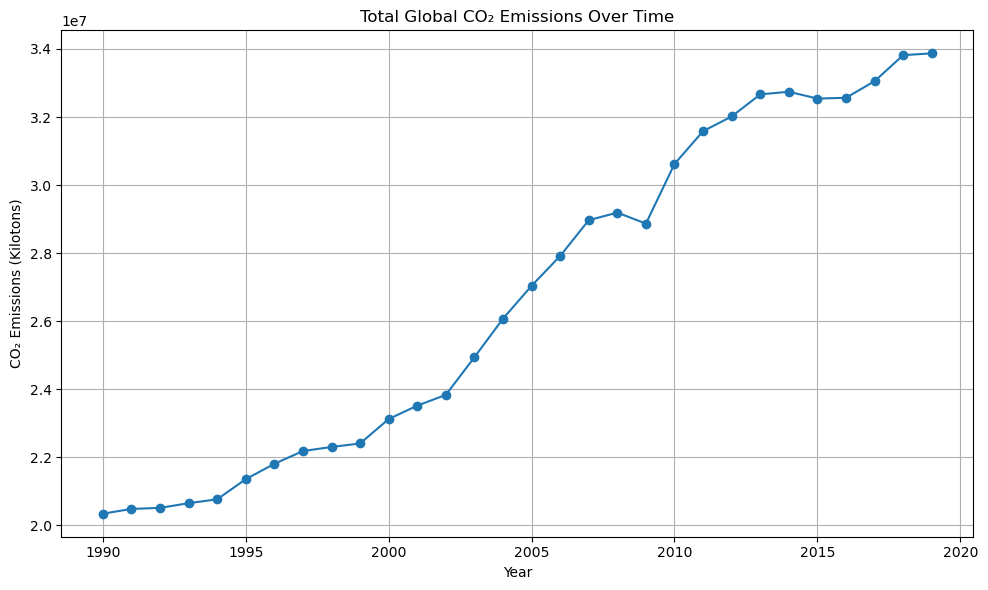

In [15]:
# Plotting first graph

# convert to Pandas for plotting
emissions_pd = emissions_by_year.toPandas()

# plot using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(emissions_pd["Year"], emissions_pd["Total_Emissions"], marker='o')
plt.title("Total Global CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (Kilotons)")
plt.grid(True)
plt.tight_layout()
plt.savefig("graph1_global_emissions.png")#saving the graph
plt.show()

### Making the second plot: Average CO₂ Emissions Per Capita by Region Over Time

In [16]:
from pyspark.sql.functions import avg, round

In [17]:
# group by the region and year, compute average per capita emissions
heatmap_data = df.groupBy("Region", "Year").agg(round(avg("Metric Tons Per Capita"), 2).alias("Avg_Per_Capita"))

# rows = Region, columns = Year, values = Avg_Per_Capita
heatmap_pivot = heatmap_data.groupBy("Region").pivot("Year").agg({"Avg_Per_Capita": "first"})

# convert to Pandas for plotting
heatmap_pd = heatmap_pivot.toPandas().set_index("Region")

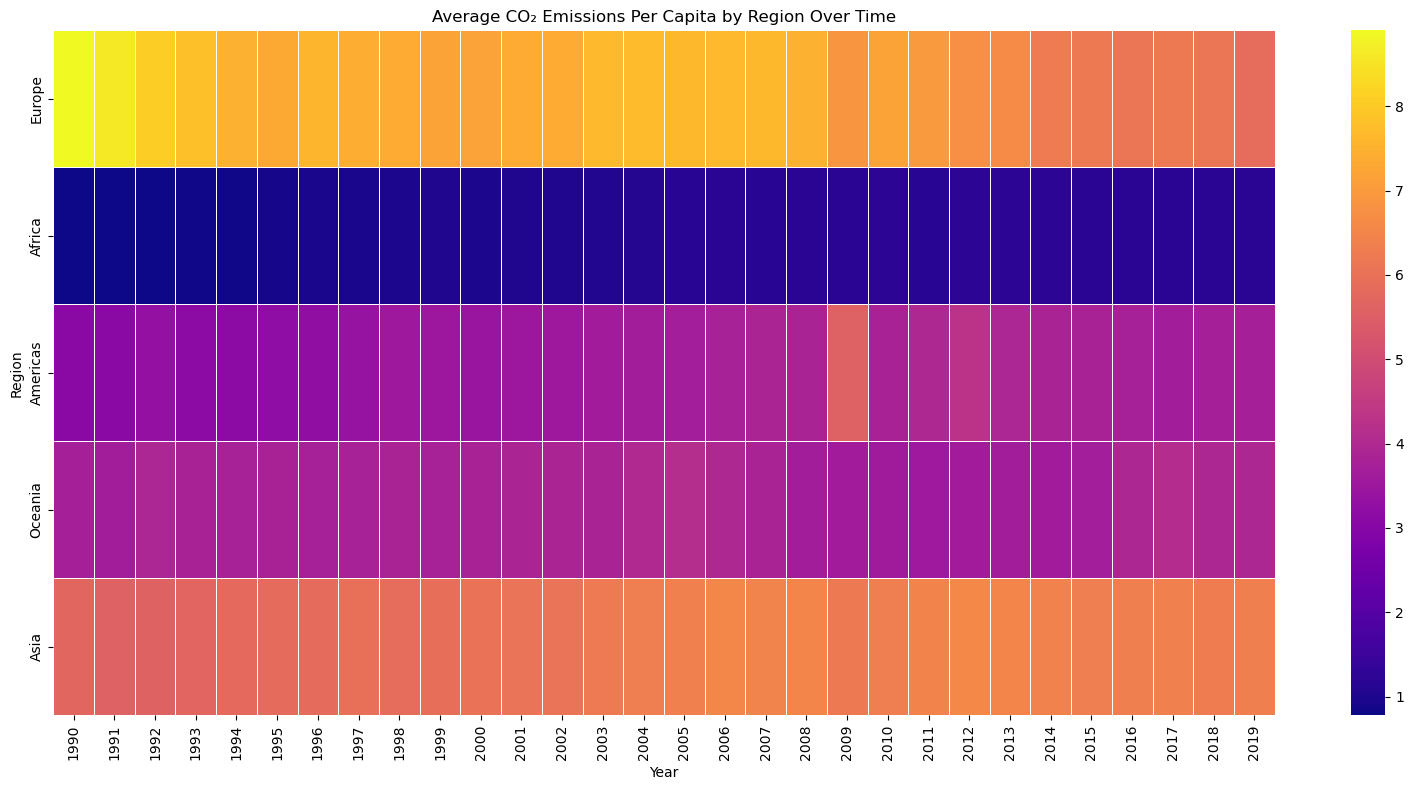

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_pd, cmap="plasma", linewidths=0.5)
plt.title("Average CO₂ Emissions Per Capita by Region Over Time")
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.savefig("graph2_per_capita_heatmap.png")#saving the graph
plt.show()

### Making the second plot: Average CO₂ Emissions Per Capita by Region Over Time

In [21]:
from pyspark.sql.functions import avg
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

In [27]:
# group by region and calculate average per capita emissions
region_df = df.groupBy("Region").agg(
    avg("Metric Tons Per Capita").alias("Avg_Per_Capita")
).dropna()


# build the pipeline stages
indexer = StringIndexer(inputCol="Region", outputCol="RegionIndex", handleInvalid="keep")
assembler = VectorAssembler(inputCols=["RegionIndex"], outputCol="features")
lr = LinearRegression(featuresCol="features", labelCol="Avg_Per_Capita")
pipeline = Pipeline(stages=[indexer, assembler, lr])

# fit the model on all data
pipeline_model = pipeline.fit(region_df)

# make predictions on the same data
predictions = pipeline_model.transform(region_df)
predictions.select("Region", "Avg_Per_Capita", "prediction").show()

# evaluate with RMSE
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Avg_Per_Capita", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

+--------+------------------+------------------+
|  Region|    Avg_Per_Capita|        prediction|
+--------+------------------+------------------+
|  Europe|  7.22273983739836| 5.282535652780744|
|  Africa|1.0524479495268075|2.5603329060599256|
|Americas|3.6467333333333287| 3.467733821633532|
| Oceania|3.8014492753623177| 6.189936568354351|
|    Asia| 6.152303290414884| 4.375134737207138|
+--------+------------------+------------------+

RMSE: 1.7281984701202742


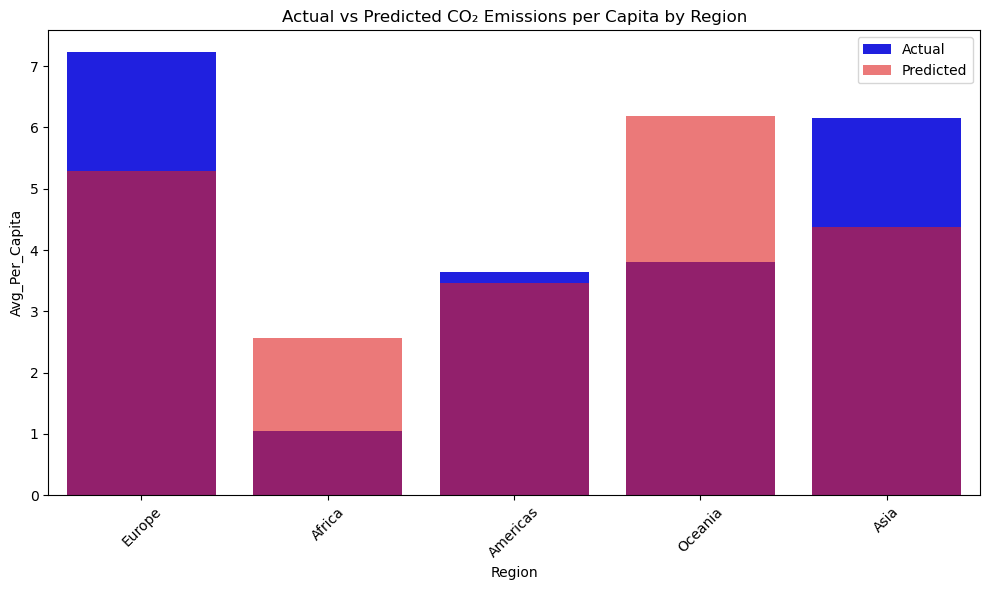

In [31]:
#visualization
pandas_df = predictions.select("Region", "Avg_Per_Capita", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=pandas_df, x="Region", y="Avg_Per_Capita", color="blue", label="Actual")
sns.barplot(data=pandas_df, x="Region", y="prediction", color="red", alpha=0.6, label="Predicted")
plt.xticks(rotation=45)
plt.legend()
plt.title("Actual vs Predicted CO₂ Emissions per Capita by Region")
plt.tight_layout()
plt.show()
